# **CSE 574 Project**
## *Real vs Fake Classification*

In [ ]:
# Imports
import datetime
import glob

from google.colab import drive
from google.colab import output as colab_op

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.model_zoo as model_zoo

import cv2
import torchvision
import numpy as np
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from random import random, choice, shuffle
from io import BytesIO
from PIL import Image
from PIL import ImageFile
from scipy.ndimage.filters import gaussian_filter
from sklearn.metrics import average_precision_score, accuracy_score, roc_auc_score, roc_curve


import matplotlib
import matplotlib.pyplot as plt
# %matplotlib inline

from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard

### *Data preprocessing, exploration and prep for training.*

In [ ]:
# mount drive to session
drive.mount('/content/drive')

### Options for managing data and training

In [ ]:
# options
shuffle = True
sampler = None
train = True
# path options

# classes = [each.split('progan/')[1].strip('/') for each in glob.glob('/content/drive/My Drive/Colab Notebooks/CNN_synth_testset/progan/*')]
# dataroot = '/content/drive/My Drive/Colab Notebooks/CNN_synth_testset/progan/'

classes = []
dataroot = '/content/drive/My Drive/Colab Notebooks/'

# augmentation options
blur_prob = 0.1
blur_sig = [0.5]
jpg_prob = 0.1
jpg_method = ['cv2']
jpg_qual = [75]
# preprocessing options
resize = 256
num_threads = 4
crop_size = 224


### Data augmentaion strategies

In [ ]:
rz_dict = {'bilinear': Image.BILINEAR,
           'bicubic': Image.BICUBIC,
           'lanczos': Image.LANCZOS,
           'nearest': Image.NEAREST}

def cv2_jpg(img, compress_val):
    img_cv2 = img[:, :, ::-1]
    encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), compress_val]
    result, encimg = cv2.imencode('.jpg', img_cv2, encode_param)
    decimg = cv2.imdecode(encimg, 1)
    return decimg[:, :, ::-1]


def pil_jpg(img, compress_val):
    out = BytesIO()
    img = Image.fromarray(img)
    img.save(out, format='jpeg', quality=compress_val)
    img = Image.open(out)
    # load from memory before ByteIO closes
    img = np.array(img)
    out.close()
    return img

jpeg_dict = {'cv2': cv2_jpg, 'pil': pil_jpg}

def jpeg_from_key(img, compress_val, key):
    method = jpeg_dict[key]
    return method(img, compress_val)


def sample_discrete(s):
    if len(s) == 1:
        return s[0]
    return choice(s)


def custom_resize(img):
    interp = sample_discrete(["bilinear"])
    return TF.resize(img, resize, interpolation=rz_dict[interp])


def sample_continuous(s):
    if len(s) == 1:
        return s[0]
    if len(s) == 2:
        rg = s[1] - s[0]
        return random() * rg + s[0]
    raise ValueError("Length of iterable s should be 1 or 2.")


def gaussian_blur(img, sigma):
    gaussian_filter(img[:, :, 0], output=img[:, :, 0], sigma=sigma)
    gaussian_filter(img[:, :, 1], output=img[:, :, 1], sigma=sigma)
    gaussian_filter(img[:, :, 2], output=img[:, :, 2], sigma=sigma)


def data_augment(img):
    img = np.array(img)

    if random() < blur_prob:
        sig = sample_continuous(blur_sig)
        gaussian_blur(img, sig)

    if random() < jpg_prob:
        method = sample_discrete(jpg_method)
        qual = sample_discrete(jpg_qual)
        img = jpeg_from_key(img, qual, method)

    return Image.fromarray(img)


### *Dataset creation code*
  - We are using pytorch's torchvision package for loading the the images and converting them into tensors.

In [ ]:
def dataset_folder(root):
  crop_func = transforms.RandomCrop if train else transforms.CenterCrop
  if train:
      flip_func = transforms.RandomHorizontalFlip()
  else:
      flip_func = transforms.Lambda(lambda img: img)
  # if not train:
  #     rz_func = transforms.Lambda(lambda img: img)
  # else:
  #     rz_func = transforms.Lambda(lambda img: custom_resize(img))
  rz_func = transforms.Lambda(lambda img: custom_resize(img))

  dset = datasets.ImageFolder(root, transforms.Compose([
          rz_func,
          transforms.Lambda(lambda img: data_augment(img)),
          crop_func(crop_size),
          flip_func,
          transforms.ToTensor(),
          transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
      ]))
  return dset


def get_dataloader(test=False):
    global train, classes
    if test:
      train = False
      classes = ['test_whichfaceisreal']
    else:
      train = True
      classes = ['whichfaceisreal']
    dset_lst = []
    for cls in classes:
        root = dataroot + '/' + cls
        dset = dataset_folder(root)
        dset_lst.append(dset)
    dataset = torch.utils.data.ConcatDataset(dset_lst)
    return torch.utils.data.DataLoader(dataset,
                                              batch_size=batch_size,
                                              shuffle=shuffle,
                                              sampler=sampler,
                                              num_workers=num_threads)

### *Model architecture description*
  - We are using pytorch's implementaion of resnet50.
  - If we choose to use pretrained weights, we will be using the weights provided by pytorch which is trained on imagenet.
  - We have opted to freeze all the layers except the 4th layer and the FC layer of the resnet50.

In [ ]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()

        self.conv1 = conv1x1(inplanes, planes)
        self.bn1 = nn.BatchNorm2d(planes)

        self.conv2 = conv3x3(planes, planes, stride)
        self.bn2 = nn.BatchNorm2d(planes)

        self.conv3 = conv1x1(planes, planes * self.expansion)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)

        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False):
        super(ResNet, self).__init__()
        self.inplanes = 64
        # Conv_1 Layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


def resnet50(pretrained=False, not_freeze=None, **kwargs):
    """Constructs a ResNet-50 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)
    if pretrained:
        state_dict = model_zoo.load_url('https://download.pytorch.org/models/resnet50-19c8e357.pth')
        state_dict['fc.weight'] = state_dict['fc.weight'][[kwargs.get('num_classes', 1)]]
        state_dict['fc.bias'] = state_dict['fc.bias'][:kwargs.get('num_classes', 1)]
        model.load_state_dict(state_dict)
        if not_freeze:
            for name, child in model.named_children():
                if name not in not_freeze:
                    for name2, params in child.named_parameters():
                        params.requires_grad = False
    return model

In [ ]:
# helper functions
def show(_img):
    npimg = _img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

def images_to_probs(net, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    pred_class = []
    prob = []
    with torch.no_grad():
      output = net(images).detach().cpu().sigmoid().squeeze().tolist()
    for p in output:
      if p>0.5:
        pred_class.append('fake')
        prob.append(p)
      else:
        pred_class.append('real')
        prob.append(1-p)
    
    return pred_class, prob


def plot_classes_preds(net, images, labels):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    _classes = ['real', 'fake']
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx].cpu())
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            preds[idx],
            probs[idx] * 100.0,
            _classes[labels[idx].cpu()]),
                    color=("green" if preds[idx]==_classes[labels[idx].item()] else "red"))
    return fig


def validate(model, data_loader_test):

    with torch.no_grad():
        y_true, y_pred = [], []
        for img, label in data_loader_test:
            in_tens = img.cuda()
            y_pred.extend(model(in_tens).sigmoid().flatten().tolist())
            y_true.extend(label.flatten().tolist())

    y_true, y_pred = np.array(y_true), np.array(y_pred)
    r_acc = accuracy_score(y_true[y_true == 0], y_pred[y_true == 0] > 0.5)
    f_acc = accuracy_score(y_true[y_true == 1], y_pred[y_true == 1] > 0.5)
    acc = accuracy_score(y_true, y_pred > 0.5)
    ap = average_precision_score(y_true, y_pred)
    return acc, ap, r_acc, f_acc, y_true, y_pred

In [ ]:
def train_model(model, epochs, lr, optimizer, criterion, data_loader, data_loader_test):
  running_loss = 0.0
  # override the learning rate
  if lr != learning_rate:
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

  for epoch in range(epochs):
    # decay the learning rate for every two epochs
    if epoch%2==0 and epoch and epoch < 5:
      lr = lr/10
      for param_group in optimizer.param_groups:
          param_group['lr'] = lr

    for batch_idx, (inputs, labels) in enumerate(data_loader):
      inputs, labels = inputs.to('cuda'), labels.to('cuda')
      optimizer.zero_grad()
      output = model(inputs)

      loss = criterion(output, labels.type_as(output).unsqueeze(1))
      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      colab_op.clear('status_text')
      with colab_op.use_tags('status_text'):
        print(f"epoch: {epoch}, batch:{batch_idx}, loss: {loss.item()}, lr: {lr}")

    writer.add_scalar(f'TrainLoss', running_loss/(len(data_loader)*batch_idx), epoch)
    writer.flush()
    running_loss = 0.0
    acc, ap, _, _, _, _ = validate(model, data_loader_test)
    writer.add_scalar('Accuracy', acc*100, epoch)
    writer.add_scalar('AP', ap, epoch)
    writer.add_figure('predictions vs. actuals', plot_classes_preds(model, inputs, labels), global_step=epoch * len(data_loader) + batch_idx)


In [ ]:
# training options
batch_size = 64
epochs = 10
learning_rate = 0.001


### *We have used tensorboard to keep track of the training metrics as it provides an interactive UI.*
  - We can also use ngrok to monitor the progress remotely as tensorboard is a webpage.

In [ ]:
!rm -rf /content/drive/My\ Drive/Colab\ Notebooks/runs
%tensorboard --logdir /content/drive/My\ Drive/Colab\ Notebooks/runs
writer = SummaryWriter('/content/drive/My Drive/Colab Notebooks/runs')
# data loaders
data_loader = get_dataloader()
data_loader_test = get_dataloader(test=True)
# training params
model = resnet50(pretrained=True, not_freeze=['layer4', 'fc'], num_classes=1).cuda().train()
lr = learning_rate
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCEWithLogitsLoss()
train_model(model, 10, lr, optimizer, criterion, data_loader, data_loader_test)

### Plotting the ROC and AUC curve

In [ ]:
torch.save(model.state_dict(), "model.torch")

'                         roc_auc_score - 0.98595'

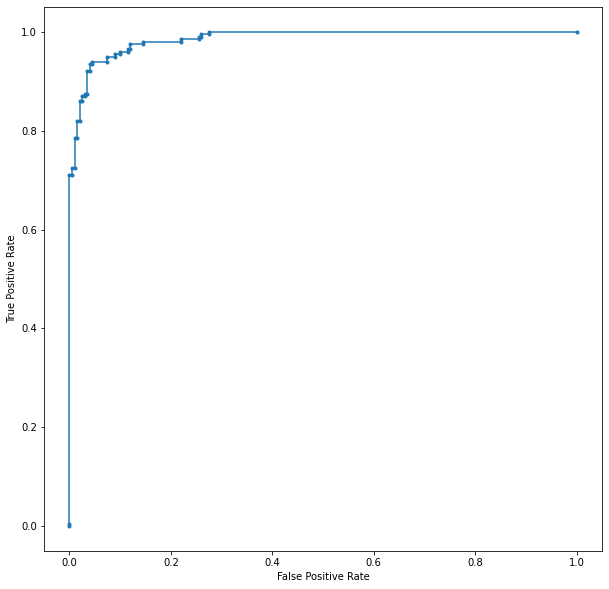

In [ ]:
with torch.no_grad():
        y_true, y_pred = [], []
        for img, label in data_loader_test:
            in_tens = img.cuda()
            y_pred.extend(model(in_tens).sigmoid().flatten().tolist())
            y_true.extend(label.flatten().tolist())

fpr, tpr, _ = roc_curve(y_true, y_pred)
# plot the roc curve for the model
fig = plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, marker='.', label='ROC Curve')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
f'                         roc_auc_score - {roc_auc_score(y_true, y_pred)}'

### The following code is to just to move around data

In [ ]:
# import glob
# import shutil

In [ ]:
# fake = glob.glob('/content/drive/My Drive/Colab Notebooks/whichfaceisreal/1_fake/*')
# real = glob.glob('/content/drive/My Drive/Colab Notebooks/whichfaceisreal/0_real/*')
# shuffle(fake)
# shuffle(real)

In [ ]:
# mkdir test_whichfaceisreal
# cd test_whichfaceisreal
# !mkdir 1_fake
# !mkdir 0_real

In [ ]:
# for i in real[:200]:
#   shutil.move(i, "0_real")

# for i in fake[:200]:
#   shutil.move(i, "1_fake")

### Server code

In [1]:
from flask import Flask, jsonify, request
from flask_cors import CORS
from glob import glob

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.model_zoo as model_zoo

import cv2
import torchvision
import numpy as np
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from random import random, choice
from io import BytesIO
from PIL import Image
from PIL import ImageFile
from scipy.ndimage.filters import gaussian_filter

In [2]:
crop_size = 224
resize = 256

def custom_resize(img):
    interp = "bilinear"
    return TF.resize(img, resize, interpolation=Image.BILINEAR)

loader = transforms.Compose([
          transforms.Lambda(lambda img: custom_resize(img)),
#           transforms.Lambda(lambda img: data_augment(img)),
          transforms.CenterCrop(crop_size),
          transforms.ToTensor(),
          transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
      ])

def image_loader(img_path):
    """load image, returns cuda tensor"""
    image = Image.open(img_path)
    image = loader(image).float().unsqueeze(0)
    return image

In [3]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()

        self.conv1 = conv1x1(inplanes, planes)
        self.bn1 = nn.BatchNorm2d(planes)

        self.conv2 = conv3x3(planes, planes, stride)
        self.bn2 = nn.BatchNorm2d(planes)

        self.conv3 = conv1x1(planes, planes * self.expansion)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)

        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False):
        super(ResNet, self).__init__()
        self.inplanes = 64
        # Conv_1 Layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


def resnet50_inference(**kwargs):
    model = ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)
    return model

In [4]:
model = resnet50_inference(num_classes=1)
model.load_state_dict(torch.load("/Users/nikhilvasudeva/Downloads/CSE574Project/model.torch", map_location=torch.device('cpu')))
model = model.eval()

In [5]:
app = Flask(__name__)
CORS(app)

In [6]:
fake_paths = glob("/Users/nikhilvasudeva/Downloads/CSE574Project/data/1_fake/*")
real_paths = glob("/Users/nikhilvasudeva/Downloads/CSE574Project/data/0_real/*")

@app.route("/get_predicitons", methods=["GET"])
def get_response():
    fake_img = choice(fake_paths)
    real_img = choice(real_paths)
    img1 = choice([fake_img, real_img])
    img2 = real_img
    fake = "img1"

    if img1 == real_img:
        fake = "img2"
        img2 = fake_img

    with torch.no_grad():
        output = model(image_loader(fake_img))
        probs = (output).sigmoid().flatten().item()

    if probs > 0.5:
        model_pred = fake
    else:
        probs = 1-probs
        if fake == "img1":
            model_pred = "img2"
        else:
            model_pred = "img1"

    print({"img1": img1, "img2": img2, "fake": fake, "model": {"fake": model_pred, "probability": int(probs*100)}})
    return jsonify({"img1": img1, "img2": img2, "fake": fake, "model": {"fake": model_pred, "probability": int(probs*100)}})

In [ ]:
app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [04/May/2020 17:16:24] "GET /get_predicitons HTTP/1.1" 200 -


{'img1': '/Users/nikhilvasudeva/Downloads/CSE574Project/data/1_fake/image-2019-02-17_022406.jpeg', 'img2': '/Users/nikhilvasudeva/Downloads/CSE574Project/data/0_real/00186.jpeg', 'fake': 'img1', 'model': {'fake': 'img1', 'probability': 99}}


127.0.0.1 - - [04/May/2020 17:39:07] "GET /get_predicitons HTTP/1.1" 200 -


{'img1': '/Users/nikhilvasudeva/Downloads/CSE574Project/data/1_fake/image-2019-02-17_025658.jpeg', 'img2': '/Users/nikhilvasudeva/Downloads/CSE574Project/data/0_real/00801.jpeg', 'fake': 'img1', 'model': {'fake': 'img2', 'probability': 68}}


127.0.0.1 - - [04/May/2020 17:39:33] "GET /get_predicitons HTTP/1.1" 200 -


{'img1': '/Users/nikhilvasudeva/Downloads/CSE574Project/data/1_fake/image-2019-02-17_020024.jpeg', 'img2': '/Users/nikhilvasudeva/Downloads/CSE574Project/data/0_real/00243.jpeg', 'fake': 'img1', 'model': {'fake': 'img1', 'probability': 98}}


127.0.0.1 - - [04/May/2020 17:45:10] "GET /get_predicitons HTTP/1.1" 200 -


{'img1': '/Users/nikhilvasudeva/Downloads/CSE574Project/data/0_real/00798.jpeg', 'img2': '/Users/nikhilvasudeva/Downloads/CSE574Project/data/1_fake/image-2019-02-17_023433.jpeg', 'fake': 'img2', 'model': {'fake': 'img2', 'probability': 99}}


127.0.0.1 - - [04/May/2020 17:57:29] "GET /get_predicitons HTTP/1.1" 200 -


{'img1': '/Users/nikhilvasudeva/Downloads/CSE574Project/data/1_fake/image-2019-02-17_022838.jpeg', 'img2': '/Users/nikhilvasudeva/Downloads/CSE574Project/data/0_real/00297.jpeg', 'fake': 'img1', 'model': {'fake': 'img1', 'probability': 99}}
